In [22]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [23]:
def Cart2Spher(positions):
    sphercoords = np.zeros(positions.shape)
    xy2 = positions[:,0]**2 + positions[:,1]**2
    sphercoords[:,0] = np.sqrt(xy2 + positions[:,2]**2)
    sphercoords[:,1] = np.arctan2(np.sqrt(xy2), positions[:,2])
    sphercoords[:,2] = np.arctan2(positions[:,1],positions[:,0])
    return sphercoords

def Spher2Cart(positions):
    cartcoords = np.zeros(positions.shape)
    cartcoords[:,0] = positions[:,0] * np.sin(positions[:,1]) * np.cos(positions[:,2])
    cartcoords[:,1] = positions[:,0] * np.sin(positions[:,1]) * np.sin(positions[:,2])
    cartcoords[:,2] = positions[:,0] * np.cos(positions[:,1])
    return cartcoords

In [24]:
def get_realtime(initial_radar_positions, current_time): # calculates radar position at a current time in rotating earth model
                                                        # current time in seconds
        timefrac = np.array(current_time) / 86164
        spherpos = Cart2Spher(initial_radar_position)
        azdiff = (timefrac * 2 * np.pi) % (2*np.pi) 
        updated_spherpos = spherpos + np.array([0, 0, azdiff])
        realtime_positions = Spher2Cart(updated_spherpos)
        return realtime_positions

In [25]:
class KalmanFilter:
    def __init__(self, initial_state, initial_covariance, process_noise_covariance, measurement_noise_covariance):
        self.state = initial_state
        self.covariance = initial_covariance
        self.process_noise_covariance = process_noise_covariance
        self.measurement_noise_covariance = measurement_noise_covariance

    def predict(self, A):
        # Predict the next state
        self.state = A @ self.state
        # Predict the next covariance
        self.covariance = A @ self.covariance @ A.T + self.process_noise_covariance

    def update(self, measurement, H):
        # Compute Kalman gain
        K = self.covariance @ H.T @ np.linalg.inv(H @ self.covariance @ H.T + self.measurement_noise_covariance)
        # Update the state estimate
        self.state = self.state + K @ (measurement - H @ self.state)
        # Update the covariance matrix
        self.covariance = self.covariance - K @ H @ self.covariance

In [26]:
def estimate_position_from_radars(radar_positions, radar_readings):
    num_radars = len(radar_positions)
    num_timesteps = len(radar_readings) // num_radars
    estimated_positions = np.zeros((num_timesteps, 3))  # To store x, y, z for each timestep

    for i in range(num_timesteps):
        timestep_readings = radar_readings.iloc[i*num_radars:(i+1)*num_radars]

        def residuals(pos):
            dists = np.sqrt((timestep_readings['x'] - pos[0])**2 +
                            (timestep_readings['y'] - pos[1])**2 +
                            (timestep_readings['z'] - pos[2])**2)
            return dists

        initial_guess = np.mean(timestep_readings, axis=0)

        # Least squares optimization
        result = least_squares(residuals, initial_guess)
        estimated_positions[i] = result.x

    return estimated_positions

In [30]:
def kalman_filter_wrapper(data_file, dt, dimension='3D', data_type = 'radar_XYZ', fixed_earth = True, plot=True, return_results=False, return_landing_position=False):
    if dimension not in ['2D', '3D']:
        raise ValueError("Invalid dimension. Dimension must be '2D' or '3D'.")

    if data_type not in ['radar_XYZ', 'radar_alt&dist', 'absolute']:
        raise ValueError("Invalid data type. Data type must be 'radar_XYZ', 'radar_alt&dist', 'absolute'.")
    
    if data_type == 'absolute': # when input data is noisy position mesaurements of satellite (NOT radar readings)
        # Load noisy measurements from CSV file
        noisy_measurements = []
        with open(data_file, 'r') as csvfile:
            csvreader = csv.reader(csvfile)
            for row in csvreader:
                x, y = map(float, row[:2]) if dimension == '2D' else map(float, row[:3])
                noisy_measurements.append([x, y]) if dimension == '2D' else noisy_measurements.append([x, y, float(row[2])])

        # Convert measurements to numpy array
        positions = np.array(noisy_measurements)

    if data_type == 'radar_XYZ': # Load radar data (which is position of satellite in (x,y,z))
        reading_columns = ['x', 'y', 'z']
        position_columns = ['x', 'y', 'z']
        radar_data_path = 'Radar_Readings.csv'
        radar_positions_path = 'Radar_Positions .csv'
        radar_data = pd.read_csv(radar_data_path, names=reading_columns)
        radar_positions = pd.read_csv(radar_positions_path, names=position_columns)
        if fixed_earth:
            positions = estimate_position_from_radars(radar_positions, radar_data)
        else:
            num_radars = len(radar_data)
            moving_radar_positions = np.zeros(len(radar_data))
            for i in range(0, len(moving_radar_positions), num_radars):
                moving_radar_positions[i:i + num_steps] = get_realtime(moving_positions[i:i+n], i * dt)
                positions.append(estimate_position_from_radars(moving_radar_positions[i:i + num_steps], radar_data[i:i + num_steps]))
            positions = np.array(positions)
            
    if data_type == 'radar_alt&dist':
        
        ##################
        #####
        ####
        
    # Define initial state, covariance matrices, process noise covariance, and measurement noise covariance
    initial_position_x, initial_position_y = positions[0]  # Set initial position to the first noisy measurement
    initial_state = np.array([initial_position_x, initial_position_y, 0, 0]) if dimension == '2D' else np.array([initial_position_x, initial_position_y, noisy_measurements[0, 2], 0, 0, 0])  # Initial position and zero velocity
    initial_covariance = np.eye(4) if dimension == '2D' else np.eye(6)  # Identity matrix
    process_noise_variance = 1e-5  # Process noise variance
    measurement_noise_variance = 1e-3  # Measurement noise variance
    process_noise_covariance = np.eye(4) * process_noise_variance if dimension == '2D' else np.eye(6) * process_noise_variance
    measurement_noise_covariance = np.eye(2) * measurement_noise_variance if dimension == '2D' else np.eye(3) * measurement_noise_variance  # Measurement noise covariance is 2x2 as we have 2D measurements

    # Initialize Kalman filter
    kf = KalmanFilter(initial_state, initial_covariance, process_noise_covariance, measurement_noise_covariance)

    # Define state transition matrix (based off a simple time step model)
    dt = 1.0  # Time step
    if dimension == '2D':
        A = np.array([[1, 0, dt, 0],
                      [0, 1, 0, dt],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]])
    else:
        A = np.array([[1, 0, 0, dt, 0, 0],
                      [0, 1, 0, 0, dt, 0],
                      [0, 0, 1, 0, 0, dt],
                      [0, 0, 0, 1, 0, 0],
                      [0, 0, 0, 0, 1, 0],
                      [0, 0, 0, 0, 0, 1]])

    # Define measurement matrix
    H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]]) if dimension == '2D' else np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0]])

    # Lists to store predicted positions
    predicted_positions = []

    # Lists to store predicted standard deviations
    predicted_std = []

    # Iterate over time steps
    for position in positions:
        # Prediction step
        kf.predict(A)
        # Update step
        kf.update(position, H)

        # Store predicted position
        predicted_positions.append(kf.state[:2]) if dimension == '2D' else predicted_positions.append(kf.state[:3])

        # Store predicted standard deviation
        predicted_std.append(np.sqrt(np.diag(kf.covariance))[:2]) if dimension == '2D' else predicted_std.append(np.sqrt(np.diag(kf.covariance))[:3])

    # Convert to numpy arrays
    predicted_positions = np.array(predicted_positions)
    predicted_std = np.array(predicted_std)

    # Plotting
    if plot:
        if dimension == '2D':
            plt.figure(figsize=(10, 6))
            plt.scatter(positions[:, 0], positions[:, 1], color='red', label='Noisy Measurements')
            plt.plot(predicted_positions[:, 0], predicted_positions[:, 1], color='blue', label='Predicted Position')
            plt.fill_between(predicted_positions[:, 0] + predicted_std[:, 0],
                             predicted_positions[:, 1] + predicted_std[:, 1],
                             predicted_positions[:, 1] - predicted_std[:, 1],
                             color='orange', alpha=0.2)
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.title('Predicted Position of the Satellite (2D)')
            plt.legend()
            plt.grid(True)
            plt.show()
        else: # unlike in 2d plot it is not possible to highlight the +/-1 std area of the predicted positions
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], color='red', label='Estimated Position based off noisy radar readings')
            ax.plot(predicted_positions[:, 0], predicted_positions[:, 1], predicted_positions[:, 2], color='blue', label='Predicted Position')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.set_title('Predicted Position of the Satellite (3D)')
            ax.legend()
            plt.show()

    if return_results:
        return predicted_positions, predicted_std
    
    if return_landing_position:
        return predicted_positions[-1], predicted_std[-1]

# Example usage:
# kalman_filter_wrapper('noisy_measurements_2d.csv', dimension='2D', data_type='radar_positions', plot=True)
# kalman_filter_wrapper('noisy_measurements_3d.csv', dimension='3D', data_type='radar_positions', plot=True)

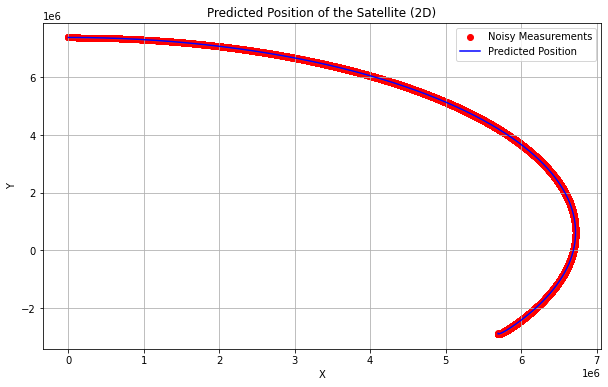

In [13]:
kalman_filter_wrapper('data_test.csv', dimension='2D', data_type='absolute', plot=True)